In [93]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [94]:
import pandas as pd

df = pd.read_excel('/content/drive/MyDrive/Project/Class Schedule/genetic alg/professor courses.xlsx')

prof_course_capacity = []
cross_listed_courses = {}
cross_listed_courses_capacity = {}  # Dictionary to record the capacity of cross-listed courses

professors = df.columns[3:27]

undergrad_courses = df.iloc[1:30, 0]
for i, course in enumerate(undergrad_courses):
    for j, professor in enumerate(professors):
        cell_value = df.iloc[i+1, j+3]
        if cell_value == 1 or cell_value == 'x':
            capacity = df.iloc[i+1, 27]
            prof_course_capacity.append((professor, course, capacity))
            if cell_value == 'x':
                if professor not in cross_listed_courses:
                    cross_listed_courses[professor] = [course]
                    cross_listed_courses_capacity[professor] = cross_listed_courses_capacity.get(professor, 0) + capacity
                else:
                    cross_listed_courses[professor].append(course)
                    cross_listed_courses_capacity[professor] += capacity

grad_courses = df.iloc[32:52, 0]
for i, course in enumerate(grad_courses):
    for j, professor in enumerate(professors):
        cell_value = df.iloc[i+32, j+3]
        if cell_value == 1 or cell_value == 'x':
            capacity = df.iloc[i+32, 27]
            prof_course_capacity.append((professor, course, capacity))
            if cell_value == 'x':
                if professor not in cross_listed_courses:
                    cross_listed_courses[professor] = [course]
                    cross_listed_courses_capacity[professor] = cross_listed_courses_capacity.get(professor, 0) + capacity
                else:
                    cross_listed_courses[professor].append(course)
                    cross_listed_courses_capacity[professor] += capacity

# Modify 'prof_course_capacity' to combine cross-listed courses
for professor, courses in cross_listed_courses.items():
    combined_course = '+'.join(courses)
    combined_capacity = cross_listed_courses_capacity[professor]  # Get the combined capacity
    for course in courses:
        for i, (prof, old_course, capacity) in enumerate(prof_course_capacity):
            if prof == professor and old_course == course:
                prof_course_capacity[i] = (professor, combined_course, combined_capacity)


# Remove duplicates
prof_course_capacity = list(set(prof_course_capacity))

course_capacity_dict = {}
for professor, course, capacity in prof_course_capacity:
    course_capacity_dict[course] = capacity


# First group the professor+course by professor
pcc_grouped = {}
for pcc in prof_course_capacity:
    professor, course, capacity = pcc
    if professor not in pcc_grouped:
        pcc_grouped[professor] = [(course, capacity)]
    else:
        pcc_grouped[professor].append((course, capacity))

# Modify undergrad_courses and Modify grad_courses
for professor, courses in cross_listed_courses.items():
    for course in courses:
        if course in undergrad_courses.values:
            undergrad_courses = undergrad_courses.replace(course, '+'.join(courses))
for professor, courses in cross_listed_courses.items():
    for course in courses:
        if course in grad_courses.values:
            grad_courses = grad_courses.replace(course, '+'.join(courses))


# Convert the grad_courses, undergrad_courses dictionary to a list of course names
grad_courses_list = grad_courses.tolist()

undergrad_courses_list = [v for k, v in undergrad_courses.items()]

# Create lists to hold the courses for each year
freshman_courses = []
sophomore_courses = []
junior_courses = []
senior_courses = []

# Go through the course list and append to the appropriate list based on the first digit of the course number
for course in undergrad_courses_list:
    course_parts = course.split(" ")  # Split the course name into parts
    course_number = course_parts[1]  # Get the course number part
    first_digit = course_number[0]  # Get the first digit of the course number

    if first_digit == "1":
        freshman_courses.append(course)
    elif first_digit == "2":
        sophomore_courses.append(course)
    elif first_digit == "3":
        junior_courses.append(course)
    elif first_digit == "4":
        senior_courses.append(course)



# Create a dictionary to hold the course capacity
course_capacity = {}
for item in prof_course_capacity:
    course = item[1]
    capacity = item[2]
    course_capacity[course] = capacity

# df2 = pd.read_excel('D:\\classroom property and availability.xlsx', sheet_name='Sheet3')
df2 = pd.read_excel('/content/drive/MyDrive/Project/Class Schedule/genetic alg/classroom property and availability_no single day_remove cs courses.xlsx', sheet_name='availability')

time_room_available = []

times = df2.columns[1:]
rooms = df2.iloc[:, 0]
for i, time in enumerate(times):
    for j, room in enumerate(rooms):
        if df2.iloc[j, i+1] == 1:  # If the value is 1, it means that the classroom is available at this time (Constraints: Class time meets classroom availability)
            time_room_available.append((time, room))

df_properties = pd.read_excel('/content/drive/MyDrive/Project/Class Schedule/genetic alg/classroom property and availability_no single day_remove cs courses.xlsx', sheet_name='property')

classroom_capacity = {}  # Capacity for storing all classrooms
classroom_distance = {}  # Used to store the distance of all classrooms

for i, row in df_properties.iterrows():
    room = row['RoomID']

    classroom_capacity[room] = row['Capacity']
    classroom_distance[room] = row['Distance']


#read professor preferred time slot
import pandas as pd
import numpy as np

df_preferences = pd.read_excel('/content/drive/MyDrive/Project/Class Schedule/genetic alg/prefessor preference no single day.xlsx',sheet_name='time')

df_preferences.set_index('Time', inplace=True)

preferences_dict = df_preferences.to_dict()

for professor, preference in preferences_dict.items():
    for time, value in preference.items():
        if pd.isna(value) or value == ' ':
            preferences_dict[professor][time] = 0
        elif isinstance(value, float):
            preferences_dict[professor][time] = int(value)







def check_schedule(schedules_list, grad_courses_list, freshman_courses, sophomore_courses, junior_courses, senior_courses, course_capacity, classroom_capacity, time_room_available,preferences_dict):
    check_grad_course_conflict(schedules_list,grad_courses_list)
    check_class_clash_for_each_level(schedules_list, freshman_courses, None, sophomore_courses)
    check_class_clash_for_each_level(schedules_list, sophomore_courses, None, junior_courses)
    check_class_clash_for_each_level(schedules_list, junior_courses, None, senior_courses)
    check_professor_conflict_schedule(schedules_list)
    check_classroom_capacity(schedules_list, course_capacity, classroom_capacity)
    check_classroom_availability(schedules_list, time_room_available)
    check_preference_score(schedules_list, preferences_dict)
#check：Graduate classes cannot clash

day_codes = ['M', 'T', 'W', 'R', 'F']

def split_timeslots_for_graduate(schedules_list):
    split_schedules = []
    for schedule in schedules_list:
        professor, course, timeslot, room = schedule
        if course not in grad_courses_list:  # Ignore if the course is not a graduate course
            continue
        days, time = timeslot.split(' ')
        for day in days:
            split_schedules.append([professor, course, day, time, room])

    # sort the list by professor's name, day of the week (MTWRF), and time
    split_schedules.sort(key=lambda x: (day_codes.index(x[2]), x[3]))
    return split_schedules


def time_to_minutes(time_string):
    # Convert a time in hhmm format to minutes past midnight
    hours = int(time_string[:2])
    minutes = int(time_string[2:])
    return hours * 60 + minutes

def check_grad_course_conflict(schedules_list, grad_courses_list):
    split_schedules = split_timeslots_for_graduate(schedules_list)

    for i in range(len(split_schedules)):
        for j in range(i+1, len(split_schedules)):
            prof1, course1, day1, time1, room1 = split_schedules[i]
            prof2, course2, day2, time2, room2 = split_schedules[j]

            # Check if we're looking at schedules for the same graduate course on the same day
            if course1 in grad_courses_list and course2 in grad_courses_list and day1 == day2:
                end_time1 = time_to_minutes(time1.split('-')[1])
                start_time2 = time_to_minutes(time2.split('-')[0])
                # Check if the start time of the second course is before the end time of the first one
                if start_time2 < end_time1:
                    print(f"Warning: Graduate courses '{prof1} {course1} {day1} {time1}' and '{prof2} {course2} {day1} {time2}' have conflict.")


def split_timeslots_for_UG(schedules_list, courses_list):
    split_schedules = []
    for schedule in schedules_list:
        professor, course, timeslot, room = schedule
        if course not in courses_list:  # Ignore if the course is not in the level's course list
            continue
        days, time = timeslot.split(' ')
        for day in days:
            split_schedules.append([professor, course, day, time, room])

    # sort the list by day of the week (MTWRF), and time
    split_schedules.sort(key=lambda x: (day_codes.index(x[2]), x[3]))
    return split_schedules

def check_class_clash_for_each_level(schedules_list, current_courses, previous_courses, next_courses):
    current_schedules = split_timeslots_for_UG(schedules_list, current_courses)

    if previous_courses:
        previous_schedules = split_timeslots_for_UG(schedules_list, previous_courses)
    else:
        previous_schedules = []

    if next_courses:
        next_schedules = split_timeslots_for_UG(schedules_list, next_courses)
    else:
        next_schedules = []

    total_schedules = previous_schedules + current_schedules + next_schedules
    for i in range(len(total_schedules)):
        prof1, course1, day1, time1, _ = total_schedules[i]
        for j in range(i+1, len(total_schedules)):
            prof2, course2, day2, time2, _ = total_schedules[j]
            # Check if we're looking at schedules for the same day
            if day1 == day2:
                start_time1 = time_to_minutes(time1.split('-')[0])
                end_time1 = time_to_minutes(time1.split('-')[1])
                start_time2 = time_to_minutes(time2.split('-')[0])
                end_time2 = time_to_minutes(time2.split('-')[1])
                # Check if the start time of the second course is before the end time of the first one and vice versa
                if (start_time2 >= start_time1 and start_time2 < end_time1) or (start_time1 >= start_time2 and start_time1 < end_time2):
                    print(f"Warning: Undergraduate courses '{course1}' and '{course2}' have time clash on {day1}.")


def split_timeslots_for_professor(schedules_list):
    split_schedules = []
    for schedule in schedules_list:
        professor, course, timeslot, room = schedule
        days, time = timeslot.split(' ')
        for day in days:
            split_schedules.append([professor, course, day, time, room])

    # sort the list by professor's name, day of the week (MTWRF), and time
    split_schedules.sort(key=lambda x: (x[0], day_codes.index(x[2]), x[3]))

    return split_schedules

def check_professor_conflict_schedule(schedules_list):
    split_schedules = split_timeslots_for_professor(schedules_list)
    for i in range(len(split_schedules)):
        for j in range(i + 1, len(split_schedules)):
            prof1, course1, day1, time1, room1 = split_schedules[i]
            prof2, course2, day2, time2, room2 = split_schedules[j]

            # Check if we're looking at schedules for the same professor on the same day
            if prof1 == prof2 and day1 == day2:
                end_time1 = time_to_minutes(time1.split('-')[1])
                start_time2 = time_to_minutes(time2.split('-')[0])
                # Check if the time difference is less than or equal to 10 minutes
                if start_time2 < end_time1:
                    print(f"Error: {prof1} has confilct classes '{course1}' and '{course2}' on {day1}.")
                elif start_time2 - end_time1 <= 10:
                    # Check if the rooms are different
                    if room1 != room2:
                        print(f"Warning: {prof1} has classes '{course1}' and '{course2}' too close together in different rooms on {day1}.")


def check_classroom_capacity(schedules_list, course_capacity, classroom_capacity):
    for schedule in schedules_list:
        professor, course, time, room = schedule
        a = course_capacity[course]
        if a is None:
            # Course capacity not specified
            continue
        b = classroom_capacity[room]
        if b is None:
            print(f"Error: Room {room} capacity not specified for course {course}.")

        if a > b:
            print(f"Capacity conflict! Course {course} with {a} students is scheduled in room {room} with capacity of {b}.")

        if int(b)/int(a) >= 2:
            print(f"Warning: Course {course} with {a} students is scheduled in room {room} with capacity of {b}, which is not suitable.")

def check_classroom_availability(schedules_list, time_room_available):
    for schedule in schedules_list:
        professor, course, time, room = schedule
        if (time, room) not in time_room_available:
            print(f"Error: Professor {professor} is scheduled to teach {course} at {time} in room {room}, which is not available!")

def check_preference_score(schedules_list, preferences_dict):
    for schedule in schedules_list:
        professor, course, time, room = schedule
        preference = int(preferences_dict.get(professor, {}).get(time, 0))
        if preference == 0:
            print(f"Warning: Professor {professor} has preference score 0 for {time}.")

Generate class scheduel by genetic algorithm:
  1. no single day course
  2. no assigned TA lab course
  3. no assigned seminar

In [122]:
import random

def generate_schedule():
    schedule = {}
    professor_time = {}
    grad_courses_times = {}
    freshman_times = {}
    sophomore_times = {}
    junior_times = {}
    senior_times = {}
    tra_copy = time_room_available.copy()
    for professor, courses in pcc_grouped.items():
        for course, capacity in courses:
            available_tra = [tra for tra in tra_copy if classroom_capacity[tra[1]] >= int(capacity)]
            if professor in professor_time:
                available_tra = [tra for tra in available_tra if tra[0] not in professor_time[professor]]
            preferred_times = preferences_dict.get(professor, {})
            available_tra = [tra for tra in available_tra if preferred_times.get(tra[0], 1) != 0]

            available_tra2 = available_tra
            available_tra3 = available_tra

            if course in freshman_courses:
                available_tra2 = [tra for tra in available_tra if tra[0] not in freshman_times and tra[0] not in sophomore_times]
            elif course in sophomore_courses:
                available_tra2 = [tra for tra in available_tra if tra[0] not in freshman_times and tra[0] not in sophomore_times and tra[0] not in junior_times]
            elif course in junior_courses:
                available_tra2 = [tra for tra in available_tra if tra[0] not in sophomore_times and tra[0] not in junior_times and tra[0] not in senior_times]
            elif course in senior_courses:
                available_tra2 = [tra for tra in available_tra if tra[0] not in junior_times and tra[0] not in senior_times]

            if course in grad_courses_list:
                available_tra3 = [tra for tra in available_tra2 if tra[0] not in grad_courses_times]

            if not available_tra3 and available_tra2:
                for tra in available_tra2:
                    if tra[0] not in grad_courses_times:
                        selected_tra = tra
                        break
                else:  # This will execute if the loop did not 'break', i.e., no valid tra was found
                    continue  # Skip to next iteration, do not attempt to remove selected_tra
            elif available_tra3:
                selected_tra = random.choice(available_tra3)
            else:
                continue  # Skip to next iteration, do not attempt to remove selected_tra


            schedule[(professor, course)] = selected_tra
            if professor not in professor_time:
                professor_time[professor] = [selected_tra[0]]
            else:
                professor_time[professor].append(selected_tra[0])

            if course in grad_courses_list:
                grad_courses_times[selected_tra[0]] = course

            # Update the times according to the course level
            if course in freshman_courses:
                freshman_times[selected_tra[0]] = course
                sophomore_times[selected_tra[0]] = course  # Freshman course clashes with Sophomore courses
            elif course in sophomore_courses:
                sophomore_times[selected_tra[0]] = course
                junior_times[selected_tra[0]] = course  # Sophomore course clashes with Junior courses
            elif course in junior_courses:
                junior_times[selected_tra[0]] = course
                senior_times[selected_tra[0]] = course  # Junior course clashes with Senior courses
            elif course in senior_courses:
                senior_times[selected_tra[0]] = course


            if selected_tra in tra_copy:
                tra_copy.remove(selected_tra)

    schedules_list = []
    for key, value in schedule.items():
        professor, course = key
        time, room = value
        schedules_list.append([professor, course, time, room])

    return schedules_list,_

def calculate_preferscore_distance(schedules_list, preferences_dict, classroom_distance):
    total_distance = 0
    total_preference_score = 0

    for schedule in schedules_list:
        professor, course, time, room = schedule
        # Calculate preference score
        preference = int(preferences_dict.get(professor, {}).get(time, 0))
        total_preference_score += preference
        # Calculate distance
        distance = classroom_distance.get(room, 0)
        total_distance += distance

    return total_preference_score, total_distance

import random

# 遗传算法参数
POPULATION_SIZE = 10
GENERATIONS = 200
CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.08

def initialize_population():
    population = []
    for _ in range(POPULATION_SIZE):
        # Retry generating the schedule until a valid schedule is found
        individual, _ = None, None
        while individual is None:
            individual, _ = generate_schedule()
        population.append(individual)
    return population


def calculate_fitness(schedules_list):
    professors_preference_score, classroom_distance_score = calculate_professors_preference_score_and_distance_socre(schedules_list)
    grad_conflict_score = calculate_grad_conflict_score(schedules_list)
    undergrad_conflict_score = calculate_undergrad_conflict_score(schedules_list,freshman_courses) + calculate_undergrad_conflict_score(schedules_list,sophomore_courses) + calculate_undergrad_conflict_score(schedules_list,junior_courses) + calculate_undergrad_conflict_score(schedules_list,senior_courses)
    print("professors_preference_score,classroom_distance_score,grad_conflict_score,undergrad_conflict_score:", professors_preference_score,classroom_distance_score,grad_conflict_score,undergrad_conflict_score)
    total_score = (professors_preference_score * 0.5 +
                classroom_distance_score * 0.5 +
                grad_conflict_score * 0.8 +
                undergrad_conflict_score * 0.8)
    return int(total_score)

def calculate_professors_preference_score_and_distance_socre(schedules_list):
    # 遍历所有的课程表，计算教授的偏好得分
    total_distance = 0
    total_preference_score = 0

    for schedule in schedules_list:
        professor, course, time, room = schedule
        preference = int(preferences_dict.get(professor, {}).get(time, 0))
        total_preference_score += preference
        # Calculate distance
        distance = classroom_distance.get(room, 0)
        total_distance += distance
    return total_preference_score, -total_distance


day_codes = ['M', 'T', 'W', 'R', 'F']

def split_timeslots_for_graduate(schedules_list):
    split_schedules = []
    for schedule in schedules_list:
        professor, course, timeslot, room = schedule
        if course not in grad_courses_list:  # Ignore if the course is not a graduate course
            continue
        # print("G:",timeslot)
        days, time = timeslot.split(' ')
        for day in days:
            split_schedules.append([professor, course, day, time, room])

    # sort the list by professor's name, day of the week (MTWRF), and time
    split_schedules.sort(key=lambda x: (day_codes.index(x[2]), x[3]))
    return split_schedules

def calculate_grad_conflict_score(schedules_list):
    split_schedules = split_timeslots_for_graduate(schedules_list)
    score = 0
    for i in range(len(split_schedules)):
            for j in range(i+1, len(split_schedules)):
                prof1, course1, day1, time1, room1 = split_schedules[i]
                prof2, course2, day2, time2, room2 = split_schedules[j]

                # Check if we're looking at schedules for the same graduate course on the same day
                if course1 in grad_courses_list and course2 in grad_courses_list and day1 == day2:
                    end_time1 = time_to_minutes(time1.split('-')[1])
                    start_time2 = time_to_minutes(time2.split('-')[0])
                    # Check if the start time of the second course is before the end time of the first one
                    if start_time2 < end_time1:
                        score += 1

    return -score

def split_timeslots_for_UG(schedules_list, courses_list):
    split_schedules = []
    for schedule in schedules_list:
        professor, course, timeslot, room = schedule
        if course not in courses_list:  # Ignore if the course is not in the level's course list
            continue
        # print("UG:",timeslot)
        days, time = timeslot.split(' ')
        for day in days:
            split_schedules.append([professor, course, day, time, room])

    # sort the list by day of the week (MTWRF), and time
    split_schedules.sort(key=lambda x: (day_codes.index(x[2]), x[3]))
    return split_schedules

def calculate_undergrad_conflict_score(schedules_list, course_levels):
    score = 0
    for i in range(len(course_levels)):
        current_courses = course_levels[i]
        previous_courses = course_levels[i - 1] if i > 0 else None
        next_courses = course_levels[i + 1] if i < len(course_levels) - 1 else None

        current_schedules = split_timeslots_for_UG(schedules_list, current_courses)

        if previous_courses:
            previous_schedules = split_timeslots_for_UG(schedules_list, previous_courses)
        else:
            previous_schedules = []

        if next_courses:
            next_schedules = split_timeslots_for_UG(schedules_list, next_courses)
        else:
            next_schedules = []

        total_schedules = previous_schedules + current_schedules + next_schedules
        for i in range(len(total_schedules)):
            prof1, course1, day1, time1, _ = total_schedules[i]
            for j in range(i+1, len(total_schedules)):
                prof2, course2, day2, time2, _ = total_schedules[j]
                # Check if we're looking at schedules for the same day
                if day1 == day2:
                    start_time1 = time_to_minutes(time1.split('-')[0])
                    end_time1 = time_to_minutes(time1.split('-')[1])
                    start_time2 = time_to_minutes(time2.split('-')[0])
                    end_time2 = time_to_minutes(time2.split('-')[1])
                    # Check if the start time of the second course is before the end time of the first one and vice versa
                    if (start_time2 >= start_time1 and start_time2 < end_time1) or (start_time1 >= start_time2 and start_time1 < end_time2):
                        score += 1
    # Calculate score
    return -score

# 选择函数
def selection(population):
    # 这里使用了轮盘赌选择
    fitnesses = [calculate_fitness(individual) for individual in population]
    total_fitness = sum(fitnesses)
    probabilities = [fitness / total_fitness for fitness in fitnesses]
    selected_index = random.choices(range(POPULATION_SIZE), probabilities)[0]
    return population[selected_index]
#生成新种群
def generate_new_population(population):
    new_population = []
    for _ in range(POPULATION_SIZE):
        selected_individual = selection(population)
        new_population.append(selected_individual)
    return new_population

def crossover(individual1, individual2):

    # Randomly select a professor
    # courses = random.sample([course[1] for course in individual1])
    # Randomly select half of the courses
    courses = random.sample([course[1] for course in individual1], len(individual1))
    # Select courses that are in grad_courses
    # courses = [course[1] for course in individual1 if course[1] in grad_courses]

    for course_name in courses:
        # Find the course in each individual
        course1 = next((course for course in individual1 if course[1] == course_name), None)
        course2 = next((course for course in individual2 if course[1] == course_name), None)

        # If the course is not in one of the individuals, skip this iteration
        if course1 is None or course2 is None:
            continue

        # Swap the time and room of these courses
        course1[2], course1[3], course2[2], course2[3] = course2[2], course2[3], course1[2], course1[3]

    return individual1, individual2


#mutate process

def mutate(individual, mutation_rate=MUTATION_RATE):
    if random.random() < mutation_rate:
        # Randomly choose a mutation type
        mutation_type = random.choice(["time", "room"])

        if mutation_type == "time":
            # preserve prof-course, mutate time but preserve classroom
            individual = mutate_time(individual)

        elif mutation_type == "room":
            # preserve prof-course, mutate classroom but preserve time
            individual = mutate_room(individual)

    return individual

def mutate_time(individual):
    # Your professor-course pair
    professor, course = individual[0], individual[1]

    # If the course is not in grad_courses, return the individual unmodified
    # if course not in grad_courses:
    #     return individual

    # Your current time and room
    current_time, current_room = individual[2], individual[3]

    # 1. Select a preferred time that is not equal to 0
    preferred_times = preferences_dict.get(professor, {})
    available_times = [time for time, score in preferred_times.items() if score != 0]

    # If no preferred times are available, return the individual unmodified
    if not available_times:
        return individual

    # 2. Select from the times that the current room is available
    room_times = [time for time, room in time_room_available if room == current_room]

    available_times = list(set(available_times) & set(room_times))

    # If no times are available, return the individual unmodified
    if not available_times:
        return individual

    # Randomly select a new time
    new_time = random.choice(available_times)

    # Replace the old time with the new time in the individual
    individual[2] = new_time

    return individual

def mutate_room(individual):
    # Your professor-course pair
    professor, course = individual[0], individual[1]

    # If the course is not in grad_courses, return the individual unmodified
    # if course not in grad_courses:
    #     return individual

    # Your current time and room
    current_time, current_room = individual[2], individual[3]

    # Get the class size for the course
    class_size = course_capacity[course]

    # 1. Select a room with capacity larger than or equal to the class size
    suitable_rooms = [room for room, capacity in classroom_capacity.items() if capacity >= class_size]

    # If no suitable rooms are available, return the individual unmodified
    if not suitable_rooms:
        return individual

    # 2. Select from the rooms that are available at the current time
    time_rooms = [room for time, room in time_room_available if time == current_time]

    suitable_rooms = list(set(suitable_rooms) & set(time_rooms))

    # If no rooms are available, return the individual unmodified
    if not suitable_rooms:
        return individual

    # Randomly select a new room
    new_room = random.choice(suitable_rooms)

    # Replace the old room with the new room in the individual
    individual[3] = new_room

    return individual



#repair process

day_codes = ['M', 'T', 'W', 'R', 'F']

def split_timeslots_for_professor(schedules_list):
    split_schedules = []
    for schedule in schedules_list:
        professor, course, timeslot, room = schedule
        days, time = timeslot.split(' ')
        for day in days:
            split_schedules.append([professor, course, day, time, room])

    # sort the list by professor's name, day of the week (MTWRF), and time
    split_schedules.sort(key=lambda x: (x[0], day_codes.index(x[2]), x[3]))

    return split_schedules

def time_to_minutes(time_string):
    # Convert a time in hhmm format to minutes past midnight
    hours = int(time_string[:2])
    minutes = int(time_string[2:])
    return hours * 60 + minutes

def check_professor_has_time_conflict(schedules_list):
    with_conflict = []
    split_schedules = split_timeslots_for_professor(schedules_list)
    for i in range(len(split_schedules)):
        for j in range(i + 1, len(split_schedules)):
            prof1, course1, day1, time1, room1 = split_schedules[i]
            prof2, course2, day2, time2, room2 = split_schedules[j]
            # Check if we're looking at schedules for the same professor on the same day
            if prof1 == prof2 and day1 == day2:
                end_time1 = time_to_minutes(time1.split('-')[1])
                start_time2 = time_to_minutes(time2.split('-')[0])
                if start_time2 < end_time1:
                    with_conflict.append([prof1, course1, '', ''])
                    with_conflict.append([prof2, course2, '', ''])
    with_conflict = [tuple(lst) for lst in with_conflict]
    with_conflict = list(set(with_conflict))
    with_conflict = [list(tup) for tup in with_conflict]

    return with_conflict

def check_UG_has_time_conflict(schedules_list, current_courses, previous_courses, next_courses):
    with_conflict = []

    current_schedules = split_timeslots_for_UG(schedules_list, current_courses)
    if previous_courses:
        previous_schedules = split_timeslots_for_UG(schedules_list, previous_courses)
    else:
        previous_schedules = []

    if next_courses:
        next_schedules = split_timeslots_for_UG(schedules_list, next_courses)
    else:
        next_schedules = []

    total_schedules = previous_schedules + current_schedules + next_schedules

    for i in range(len(total_schedules)):
        prof1, course1, day1, time1, _ = total_schedules[i]
        for j in range(i+1, len(total_schedules)):
            prof2, course2, day2, time2, _ = total_schedules[j]
            # Check if we're looking at schedules for the same day
            if day1 == day2:
                start_time1 = time_to_minutes(time1.split('-')[0])
                end_time1 = time_to_minutes(time1.split('-')[1])
                start_time2 = time_to_minutes(time2.split('-')[0])
                end_time2 = time_to_minutes(time2.split('-')[1])
                # Check if the start time of the second course is before the end time of the first one and vice versa
                if (start_time2 >= start_time1 and start_time2 < end_time1) or (start_time1 >= start_time2 and start_time1 < end_time2):
                    with_conflict.append([prof1, course1, '', ''])
                    with_conflict.append([prof2, course2, '', ''])
    with_conflict = [tuple(lst) for lst in with_conflict]
    with_conflict = list(set(with_conflict))
    with_conflict = [list(tup) for tup in with_conflict]

    return with_conflict

def check_grad_has_time_conflict(schedules_list, grad_courses_list):
    split_schedules = split_timeslots_for_graduate(schedules_list)

    with_conflict = [] # Create an empty list to store schedules with conflicts

    for i in range(len(split_schedules)):
        for j in range(i+1, len(split_schedules)):
            prof1, course1, day1, time1, room1 = split_schedules[i]
            prof2, course2, day2, time2, room2 = split_schedules[j]

            # Check if we're looking at schedules for the same graduate course on the same day
            if course1 in grad_courses_list and course2 in grad_courses_list and day1 == day2:
                end_time1 = time_to_minutes(time1.split('-')[1])
                start_time2 = time_to_minutes(time2.split('-')[0])
                # Check if the start time of the second course is before the end time of the first one
                if start_time2 < end_time1:
                    # Append the conflicting schedules to the list
                    with_conflict.append([prof1, course1, '', ''])
                    with_conflict.append([prof2, course2, '', ''])

    # Remove duplicates from the list
    with_conflict = [tuple(lst) for lst in with_conflict]
    with_conflict = list(set(with_conflict))
    with_conflict = [list(tup) for tup in with_conflict]

    return with_conflict


def check_time_classroom_conflict(time, room):
    #check if time and room are available
    return (time, room) not in time_room_available
def check_professor_preference_score(professor, time):
    #check if the professor has preference score = 0 at this time
    if preferences_dict[professor][time] == 0:
        return True
    else:
        return False
def check_class_capacity_conflict(course, room):
    return course_capacity[course] > classroom_capacity[room]


def find_valid_time_room(professor, course, professor_time):
    available_tra = [tra for tra in time_room_available if classroom_capacity[tra[1]] >= int(course_capacity[course])]

    # Remove the time slots that professor doesn't prefer
    preferred_times = preferences_dict.get(professor, {})
    available_tra = [tra for tra in available_tra if preferred_times.get(tra[0], 1) != 0]

    if professor in professor_time:  # If the professor already has allocated time, it needs to be removed
        available_tra = [tra for tra in available_tra if tra[0] not in professor_time[professor]]

    if not available_tra:
        print("cannot find valid time and room!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        return None, None  # No valid schedule, exit the function

    # Randomly select one of the time-classroom combinations that meet the constraints
    selected_tra = random.choice(available_tra)

    return selected_tra[0], selected_tra[1]


def find_valid_time_room_2(professor, course, professor_time, UG_courses_times, grad_courses_times):
    available_tra = [tra for tra in time_room_available if classroom_capacity[tra[1]] >= int(course_capacity[course])]

    # Remove the time slots that professor doesn't prefer
    preferred_times = preferences_dict.get(professor, {})
    available_tra = [tra for tra in available_tra if preferred_times.get(tra[0], 1) != 0]

    # Remove the time slots that have undergraduate courses at this time
    if course in freshman_courses:
        available_tra = [tra for tra in available_tra if tra[0] not in UG_courses_times['freshman'] and tra[0] not in UG_courses_times['sophomore']]
    elif course in sophomore_courses:
        available_tra = [tra for tra in available_tra if tra[0] not in UG_courses_times['freshman'] and tra[0] not in UG_courses_times['sophomore'] and tra[0] not in UG_courses_times['junior']]
    elif course in junior_courses:
        available_tra = [tra for tra in available_tra if tra[0] not in UG_courses_times['sophomore'] and tra[0] not in UG_courses_times['junior'] and tra[0] not in UG_courses_times['senior']]
    elif course in senior_courses:
        available_tra = [tra for tra in available_tra if tra[0] not in UG_courses_times['junior'] and tra[0] not in UG_courses_times['senior']]

    if professor in professor_time:  # If the professor already has allocated time, it needs to be removed
        available_tra = [tra for tra in available_tra if tra[0] not in professor_time[professor]]

    if course in grad_courses_list:
        available_tra = [tra for tra in available_tra if tra[0] not in grad_courses_times]

    if not available_tra:
        # Relax constraints and only ensure professor's time is not conflicted
        available_tra = [tra for tra in time_room_available if tra[0] not in professor_time[professor] and tra[0] not in grad_courses_times]

    if not available_tra:
        # Relax constraints and only ensure professor's time is not conflicted
        available_tra = [tra for tra in time_room_available if tra[0] not in professor_time[professor]]
        if course in freshman_courses:
            available_tra = [tra for tra in available_tra if tra[0] not in UG_courses_times['freshman'] and tra[0] not in UG_courses_times['sophomore']]
        elif course in sophomore_courses:
            available_tra = [tra for tra in available_tra if tra[0] not in UG_courses_times['freshman'] and tra[0] not in UG_courses_times['sophomore'] and tra[0] not in UG_courses_times['junior']]
        elif course in junior_courses:
            available_tra = [tra for tra in available_tra if tra[0] not in UG_courses_times['sophomore'] and tra[0] not in UG_courses_times['junior'] and tra[0] not in UG_courses_times['senior']]
        elif course in senior_courses:
            available_tra = [tra for tra in available_tra if tra[0] not in UG_courses_times['junior'] and tra[0] not in UG_courses_times['senior']]

    if not available_tra:
        available_tra = [tra for tra in time_room_available if tra[0] not in professor_time[professor]]

    # Randomly select one of the time-classroom combinations that meet the constraints
    selected_tra = random.choice(available_tra)

    return selected_tra[0], selected_tra[1]





def repair_schedule(schedules_list):
    professor_time = {professor: [] for professor in professors}
    without_conflict = []
    with_conflict = []
    with_conflict=check_professor_has_time_conflict(schedules_list)
    with_conflict.extend(check_UG_has_time_conflict(schedules_list, freshman_courses, None, sophomore_courses))
    with_conflict.extend(check_UG_has_time_conflict(schedules_list, sophomore_courses, None, junior_courses))
    with_conflict.extend(check_UG_has_time_conflict(schedules_list, junior_courses, None, senior_courses))

    # Convert each sublist into tuple to make it hashable for set
    with_conflict = [tuple(conflict) for conflict in with_conflict]

    # Remove duplicates by converting the list to a set and then back to a list
    with_conflict = list(set(with_conflict))

    # Convert each tuple back into list
    with_conflict = [list(conflict) for conflict in with_conflict]

    for i in range(len(schedules_list)):
        schedule = schedules_list[i]
        professor, course, timeslot, room = schedule
        if check_class_capacity_conflict(course, room) or check_time_classroom_conflict(timeslot, room) or check_professor_preference_score(professor, timeslot):
            #if with_conflict has the same professor, course, then skip
            if [professor, course, '', ''] in with_conflict:
                continue
            with_conflict.append(schedule)

    conflict_courses = [schedule[1] for schedule in with_conflict]
    without_conflict = [schedule for schedule in schedules_list if schedule[1] not in conflict_courses]
    for schedule in without_conflict:
        professor, course, timeslot, room = schedule
        if professor not in professor_time:
            professor_time[professor] = [timeslot]
        else:
            if timeslot not in professor_time[professor]:
                professor_time[professor].append(timeslot)

    for i in range(len(with_conflict)):
        schedule = with_conflict[i]
        professor, course, timeslot, room = schedule
        new_timeslot, new_room = find_valid_time_room(professor, course, professor_time)
        if new_timeslot and new_room:  # If a valid time and room are found
            with_conflict[i] = [professor, course, new_timeslot, new_room]
            professor_time[professor].append(new_timeslot)

    # Merge without_conflict and with_conflict to get the repaired schedules
    repaired_schedules = without_conflict + with_conflict

    return repaired_schedules

def repair_schedule_2(schedules_list):
    professor_time = {professor: [] for professor in professors}

    # Create a dictionary to hold the times of the UG courses
    UG_courses_times = {
        'freshman': [],
        'sophomore': [],
        'junior': [],
        'senior': [],
    }
    grad_courses_times = {grad_course:[] for grad_course in grad_courses_list}

    without_conflict = []
    with_conflict = []
    with_conflict = check_professor_has_time_conflict(schedules_list)
    with_conflict.extend(check_grad_has_time_conflict(schedules_list,grad_courses_list))
    with_conflict.extend(check_UG_has_time_conflict(schedules_list, freshman_courses, None, sophomore_courses))
    with_conflict.extend(check_UG_has_time_conflict(schedules_list, sophomore_courses, None, junior_courses))
    with_conflict.extend(check_UG_has_time_conflict(schedules_list, junior_courses, None, senior_courses))

    # Convert each sublist into tuple to make it hashable for set
    with_conflict = [tuple(conflict) for conflict in with_conflict]

    # Remove duplicates by converting the list to a set and then back to a list
    with_conflict = list(set(with_conflict))

    # Convert each tuple back into list
    with_conflict = [list(conflict) for conflict in with_conflict]

    for i in range(len(schedules_list)):
        schedule = schedules_list[i]
        professor, course, timeslot, room = schedule
        if check_class_capacity_conflict(course, room) or check_time_classroom_conflict(timeslot, room) or check_professor_preference_score(professor, timeslot):
            #if with_conflict has the same professor, course, then skip
            if [professor, course, '', ''] in with_conflict:
                continue
            with_conflict.append(schedule)

    conflict_courses = [schedule[1] for schedule in with_conflict]
    without_conflict = [schedule for schedule in schedules_list if schedule[1] not in conflict_courses]
    for schedule in without_conflict:
        professor, course, timeslot, room = schedule
        if professor not in professor_time:
            professor_time[professor] = [timeslot]
        else:
            if timeslot not in professor_time[professor]:
                professor_time[professor].append(timeslot)

        if course in grad_courses_list:
            grad_courses_times[course].append(timeslot)

        # Update the times according to the course level
        if course in freshman_courses:
            UG_courses_times['freshman'].append(timeslot)
            UG_courses_times['sophomore'].append(timeslot)  # Freshman course clashes with Sophomore courses
        elif course in sophomore_courses:
            UG_courses_times['sophomore'].append(timeslot)
            UG_courses_times['junior'].append(timeslot)  # Sophomore course clashes with Junior courses
        elif course in junior_courses:
            UG_courses_times['junior'].append(timeslot)
            UG_courses_times['senior'].append(timeslot)  # Junior course clashes with Senior courses
        elif course in senior_courses:
            UG_courses_times['senior'].append(timeslot)

    for i in range(len(with_conflict)):
        schedule = with_conflict[i]
        professor, course, timeslot, room = schedule
        new_timeslot, new_room = find_valid_time_room_2(professor, course, professor_time, UG_courses_times,grad_courses_times)
        if new_timeslot and new_room:  # If a valid time and room are found
            with_conflict[i] = [professor, course, new_timeslot, new_room]
            professor_time[professor].append(new_timeslot)

            if course in grad_courses_list:
                grad_courses_times[course].append(new_timeslot)

            # Update the times according to the course level
            if course in freshman_courses:
                UG_courses_times['freshman'].append(new_timeslot)
                UG_courses_times['sophomore'].append(new_timeslot)  # Freshman course clashes with Sophomore courses
            elif course in sophomore_courses:
                UG_courses_times['sophomore'].append(new_timeslot)
                UG_courses_times['junior'].append(new_timeslot)  # Sophomore course clashes with Junior courses
            elif course in junior_courses:
                UG_courses_times['junior'].append(new_timeslot)
                UG_courses_times['senior'].append(new_timeslot)  # Junior course clashes with Senior courses
            elif course in senior_courses:
                UG_courses_times['senior'].append(new_timeslot)

    # Merge without_conflict and with_conflict to get the repaired schedules
    repaired_schedules = without_conflict + with_conflict

    return repaired_schedules



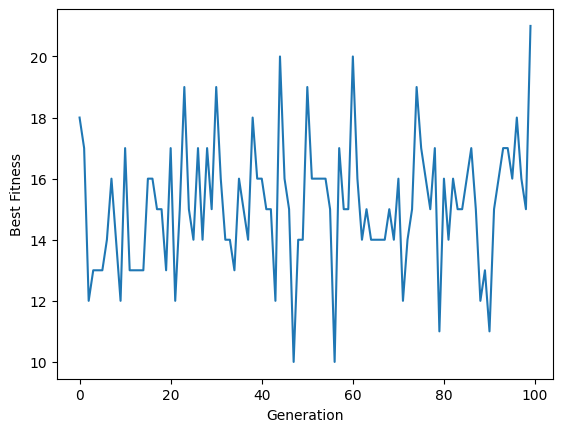

professors_preference_score,classroom_distance_score,grad_conflict_score,undergrad_conflict_score: 58 -9.500000000000004 -4 0
Best Fitness: 21
Best schedule: [['Uma Chinta', 'CS 5381 cs core 2', 'MWF 1300-1350', 'TFPETR 00110'], ['Shin', 'CS 4331SS (elective)', 'TR 1700-1820', 'CHEM 00025'], ['Uma Chinta', 'CS 1412-002', 'MWF 1200-1250', 'BIOL 00021'], ['Don ', 'CS 3365', 'TR 0930-1050', 'HOLDEN 00076'], ['Rees', 'CS 4331B (elective)+CS 5393', 'MWF 1000-1050', 'ELECE 00101'], ['Siami Namin', 'CS 6345', 'MWF 1200-1250', 'LVRMRC 00101'], ['Lim', 'CS 3375', 'MWF 1700-1750', 'ELECE 00101'], ['Sheng', 'CS 3364', 'TR 1100-1220', 'IMSE 00121'], ['Morshed', 'CS 3350', 'MWF 0900-0950', 'HOLDEN 00077'], ['Nguyen', 'CS 4331SA (elective)+CS 5332', 'TR 1830-1950', 'AGRI 00214'], ['Chen, Yong', 'CS 4352', 'MWF 1100-1150', 'HOLDEN 00005'], ['Rees', 'CS 3361', 'TR 1400-1520', 'ELECE 00101'], ['Lu   Wei', 'CS 3383', 'MWF 1600-1650', 'HUMSCI 00063'], ['Zhuang', 'CS 5375 cs core', 'MWF 1500-1550', 'HOLDE

In [107]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import copy
def run_genetic_algorithm():
    # Initialize the population
    population = initialize_population()

    # Create a list to store the fitness scores for each generation
    fitness_scores = []

    # Initialize the best individual
    best_individual = population[0]

    # Run the genetic algorithm
    for generation in range(GENERATIONS):
        print(f"Generation {generation+1}")

        # Generate new population through selection
        new_population = generate_new_population(population)

        # Perform crossover
        for i in range(0, POPULATION_SIZE - 1, 2):
            if random.random() < CROSSOVER_RATE:
                new_population[i], new_population[i+1] = crossover(new_population[i], new_population[i+1])

        # Perform mutation
        for i in range(len(new_population)):
            for j in range(len(new_population[i])):
                new_population[i][j] = mutate(new_population[i][j])

        # Repair the population
        for i in range(POPULATION_SIZE):
            new_population[i] = repair_schedule_2(new_population[i])

        # Replace the old population with the new population
        population = new_population.copy()

        # Calculate the best (maximum) fitness in the current population
        current_best_individual = max(population, key=calculate_fitness)
        current_best_fitness = calculate_fitness(current_best_individual)
        fitness_scores.append(current_best_fitness)

        # If the current best individual is better than the overall best, update the best individual
        if calculate_fitness(best_individual) < current_best_fitness:
            best_individual = copy.deepcopy(current_best_individual)


        # Clear the previous plot and plot the new fitness scores
        clear_output(wait=True)
        plt.plot(range(generation+1), fitness_scores)
        plt.xlabel('Generation')
        plt.ylabel('Best Fitness')
        plt.show()
        plt.pause(0.1)

    print("Best Fitness:", calculate_fitness(best_individual))
    return best_individual

best_schedule = run_genetic_algorithm()

print("Best schedule:", best_schedule)


In [108]:
best_schedule

[['Uma Chinta', 'CS 5381 cs core 2', 'MWF 1300-1350', 'TFPETR 00110'],
 ['Shin', 'CS 4331SS (elective)', 'TR 1700-1820', 'CHEM 00025'],
 ['Uma Chinta', 'CS 1412-002', 'MWF 1200-1250', 'BIOL 00021'],
 ['Don ', 'CS 3365', 'TR 0930-1050', 'HOLDEN 00076'],
 ['Rees', 'CS 4331B (elective)+CS 5393', 'MWF 1000-1050', 'ELECE 00101'],
 ['Siami Namin', 'CS 6345', 'MWF 1200-1250', 'LVRMRC 00101'],
 ['Lim', 'CS 3375', 'MWF 1700-1750', 'ELECE 00101'],
 ['Sheng', 'CS 3364', 'TR 1100-1220', 'IMSE 00121'],
 ['Morshed', 'CS 3350', 'MWF 0900-0950', 'HOLDEN 00077'],
 ['Nguyen', 'CS 4331SA (elective)+CS 5332', 'TR 1830-1950', 'AGRI 00214'],
 ['Chen, Yong', 'CS 4352', 'MWF 1100-1150', 'HOLDEN 00005'],
 ['Rees', 'CS 3361', 'TR 1400-1520', 'ELECE 00101'],
 ['Lu   Wei', 'CS 3383', 'MWF 1600-1650', 'HUMSCI 00063'],
 ['Zhuang', 'CS 5375 cs core', 'MWF 1500-1550', 'HOLDEN 00104'],
 ['Alam', 'CS 2365', 'TR 1700-1820', 'LAW 00106'],
 ['Alam', 'CS 1412-001', 'TR 0800-0920', 'HOLDEN 00076'],
 ['Jingjing Yao', 'CS 538

In [110]:
calculate_preferscore_distance(best_schedule,preferences_dict, classroom_distance)

(58, 9.500000000000004)

In [109]:
check_schedule(best_schedule, grad_courses_list, freshman_courses, sophomore_courses, junior_courses, senior_courses, course_capacity, classroom_capacity, time_room_available, preferences_dict)

**Fix incomplete class schedule**

In [112]:
def convert_input_to_fixed_schedule(input_list):
    fixed_schedule = {}
    for item in input_list:
        professor, course, time, room = item
        key = (professor, course)
        value = (time, room)
        fixed_schedule[key] = value
    return fixed_schedule

def initialize_fixed_schedule_vars(fixed_schedule):
    professor_time = {}
    grad_courses_times = {}
    freshman_times = {}
    sophomore_times = {}
    junior_times = {}
    senior_times = {}

    for (professor, course), (time, room) in fixed_schedule.items():
        if professor not in professor_time:
            professor_time[professor] = [time]
        else:
            professor_time[professor].append(time)

        if course in grad_courses_list:
            grad_courses_times[time] = course

        if course in freshman_courses:
            freshman_times[time] = course
        elif course in sophomore_courses:
            sophomore_times[time] = course
        elif course in junior_courses:
            junior_times[time] = course
        elif course in senior_courses:
            senior_times[time] = course

    return professor_time, grad_courses_times, freshman_times, sophomore_times, junior_times, senior_times

def generate_schedule(input_list=None):
    if input_list:
        fixed_schedule = convert_input_to_fixed_schedule(input_list)
        professor_time, grad_courses_times, freshman_times, sophomore_times, junior_times, senior_times = initialize_fixed_schedule_vars(fixed_schedule)
    else:
        fixed_schedule = {}
        professor_time = {}
        grad_courses_times = {}
        freshman_times = {}
        sophomore_times = {}
        junior_times = {}
        senior_times = {}

    schedule = fixed_schedule.copy()
    tra_copy = time_room_available.copy()

    for professor, courses in pcc_grouped.items():
        for course, capacity in courses:
            if (professor, course) in schedule:  # skip the already fixed course
                continue

            # Begin original scheduling logic
            available_tra = [tra for tra in tra_copy if classroom_capacity[tra[1]] >= int(capacity)]

            if professor in professor_time:
                available_tra = [tra for tra in available_tra if tra[0] not in professor_time[professor]]

            preferred_times = preferences_dict.get(professor, {})
            available_tra = [tra for tra in available_tra if preferred_times.get(tra[0], 1) != 0]

            available_tra2 = available_tra

            if course in freshman_courses:
                available_tra2 = [tra for tra in available_tra if tra[0] not in freshman_times and tra[0] not in sophomore_times]
            elif course in sophomore_courses:
                available_tra2 = [tra for tra in available_tra if tra[0] not in freshman_times and tra[0] not in sophomore_times and tra[0] not in junior_times]
            elif course in junior_courses:
                available_tra2 = [tra for tra in available_tra if tra[0] not in sophomore_times and tra[0] not in junior_times and tra[0] not in senior_times]
            elif course in senior_courses:
                available_tra2 = [tra for tra in available_tra if tra[0] not in junior_times and tra[0] not in senior_times]

            available_tra3 = [tra for tra in available_tra2 if tra[0] not in grad_courses_times] if course in grad_courses_list else available_tra2

            if not available_tra3 and available_tra2:
                for tra in available_tra2:
                    if tra[0] not in grad_courses_times:
                        selected_tra = tra
                        break
                else:  # If loop did not 'break', no valid tra was found
                    continue
            elif available_tra3:
                selected_tra = random.choice(available_tra3)
            else:
                continue

            schedule[(professor, course)] = selected_tra
            if professor not in professor_time:
                professor_time[professor] = [selected_tra[0]]
            else:
                professor_time[professor].append(selected_tra[0])

            if course in grad_courses_list:
                grad_courses_times[selected_tra[0]] = course

            if course in freshman_courses:
                freshman_times[selected_tra[0]] = course
                sophomore_times[selected_tra[0]] = course
            elif course in sophomore_courses:
                sophomore_times[selected_tra[0]] = course
                junior_times[selected_tra[0]] = course
            elif course in junior_courses:
                junior_times[selected_tra[0]] = course
                senior_times[selected_tra[0]] = course
            elif course in senior_courses:
                senior_times[selected_tra[0]] = course

            if selected_tra in tra_copy:
                tra_copy.remove(selected_tra)

    schedules_list = []
    for key, value in schedule.items():
        professor, course = key
        time, room = value
        schedules_list.append([professor, course, time, room])

    return schedules_list

In [120]:
# Now we can generate a schedule based on a fixed schedule:
input_schedule = [['Lim', 'CS 3375', 'MWF 1700-1750', 'IMSE 00121'],
 ['Don ', 'CS 2413-001', 'MWF 1600-1650', 'AGRI 00214'],
 ['Dang', 'CS 4366', 'TR 2000-2120', 'BIOL LH100'],
 ['Uma Chinta', 'CS 1412-002', 'MWF 1300-1350', 'MCOM 00057'],
 ['Uma Chinta', 'CS 5381 cs core 2', 'MWF 1200-1250', 'HUMSCI 00169'],
 ['Serwadda', 'CS 4354', 'MWF 1400-1450', 'HOLDEN 00104'],
 ['Uma Chinta', 'CS 2413-002', 'MWF 0800-0850', 'HOLDEN 00077'],
 ['Shin', 'CS 4331SS (elective)', 'TR 0800-0920', 'HOLDEN 00076'],
 ['Alam', 'CS 1412-001', 'TR 0800-0920', 'HOLDEN 00075'],
 ['Mengel', 'CS 4331DL (elective)', 'TR 1700-1820', 'LVRMRC 00104'],
 ['Nguyen', 'CS 4331SA (elective)+CS 5332', 'TR 1230-1350', 'AGRI 00214'],
 ['Don ', 'CS 3365', 'TR 1830-1950', 'ENGPHL 00001'],
 ['Alam', 'CS 1382-001', 'TR 1830-1950', 'CIVILE 00205'],
 ['Rees', 'CS 4331B (elective)+CS 5393', 'MWF 0900-0950', 'HOLDEN 00077'],
 ['F2', 'CS 5384 cs core', 'MWF 0800-0850', 'HOLDEN 00104'],
 ['Nguyen', 'CS 5356', 'MWF 1700-1750', 'AGRI 00214'],
 ['Sheng', 'CS 5388', 'TR 0800-0920', 'CHEM 00049'],
 ['Shin', 'CS 5373 se core', 'MWF 1300-1350', 'ELECE 00101'],
 ['Lu   Wei', 'CS 3383', 'MWF 1000-1050', 'ELECE 00101'],
 ['Siami Namin', 'CS 6345', 'TR 1700-1820', 'MCOM 00353'],
 ['Zhuang', 'CS 5375 cs core', 'MWF 1500-1550', 'HOLDEN 00104'],
 ['Rees', 'CS 3361', 'TR 1400-1520', 'AGRI 00214']]
output_schedule = generate_schedule(input_schedule)
output_schedule

[['Lim', 'CS 3375', 'MWF 1700-1750', 'IMSE 00121'],
 ['Don ', 'CS 2413-001', 'MWF 1600-1650', 'AGRI 00214'],
 ['Dang', 'CS 4366', 'TR 2000-2120', 'BIOL LH100'],
 ['Uma Chinta', 'CS 1412-002', 'MWF 1300-1350', 'MCOM 00057'],
 ['Uma Chinta', 'CS 5381 cs core 2', 'MWF 1200-1250', 'HUMSCI 00169'],
 ['Serwadda', 'CS 4354', 'MWF 1400-1450', 'HOLDEN 00104'],
 ['Uma Chinta', 'CS 2413-002', 'MWF 0800-0850', 'HOLDEN 00077'],
 ['Shin', 'CS 4331SS (elective)', 'TR 0800-0920', 'HOLDEN 00076'],
 ['Alam', 'CS 1412-001', 'TR 0800-0920', 'HOLDEN 00075'],
 ['Mengel', 'CS 4331DL (elective)', 'TR 1700-1820', 'LVRMRC 00104'],
 ['Nguyen', 'CS 4331SA (elective)+CS 5332', 'TR 1230-1350', 'AGRI 00214'],
 ['Don ', 'CS 3365', 'TR 1830-1950', 'ENGPHL 00001'],
 ['Alam', 'CS 1382-001', 'TR 1830-1950', 'CIVILE 00205'],
 ['Rees', 'CS 4331B (elective)+CS 5393', 'MWF 0900-0950', 'HOLDEN 00077'],
 ['F2', 'CS 5384 cs core', 'MWF 0800-0850', 'HOLDEN 00104'],
 ['Nguyen', 'CS 5356', 'MWF 1700-1750', 'AGRI 00214'],
 ['Sheng'

In [121]:
check_schedule(output_schedule, grad_courses_list, freshman_courses, sophomore_courses, junior_courses, senior_courses, course_capacity_dict, classroom_capacity, time_room_available, preferences_dict)